# Rock-Uplift-Water

### import declaration

In [8]:
import landlab
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, LinearDiffuser, Lithology, LithoLayers, SinkFillerBarnes, NormalFault
from landlab.plot import imshow_grid
import numpy as np 
import time

import matplotlib.pyplot as plt

## initialise Grid

We initialise a grid that is 100 km x 100 km wide, in units of *metres*. The boundaries are fixed at zero at the top and bottom but left closed at the east and west. Uniform noise up to 10 metres of elevation is added at all points in the landscape to allow for channelisation.

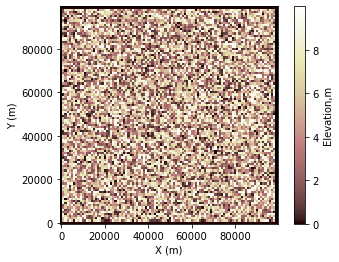

In [63]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]
imshow_grid(grid,'topographic__elevation',var_name="Elevation,m")

## Initialise Components

### Flowrouting

First we initialise the flowrouter and a sink-filler that fills in the pits in the random topography allowing for channelisation to occur. We display the drainage area that results from these calculations below.

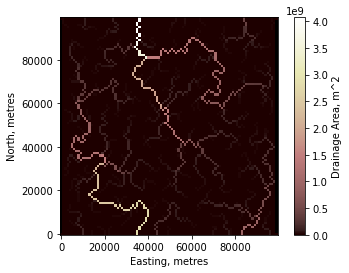

In [64]:
sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2")
plt.xlabel("Easting, metres") 
plt.ylabel("North, metres")
plt.show()

### Erosion and diffusion

Next we initialise the stream power law eroder and the linear diffuser using realistic values. 

For the parameters $n$ and $m$ we use 1, and 0.5 respectively. 

For $K_{sp}$, a reasonable range appears to be $10^{-2}$ to $10^{-4}$ m/kyr. For $D_{diff}$, a reasonable range appears to be anything less than $10^{3}$ m$^2$/kyr. These ranges are broadly supported by real-life studies e.g. ([Roberts & White](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009JB006692), [Rosenblum & Anderson](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94JB00048)), although wider ranges have been reported (e.g. see [Campforts 2015](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94JB00048))




In [65]:
n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

peclet = ((nx*dx)*K_sp)/D_diff
print("Peclet number =",peclet)

Peclet number = 100.0


#### Time-step calculations

Using these values we now calculate the appropriate timesteps so that these advective and diffusive timesteps can be performed correctly.

For the advective model, $dt < \frac{dx}{K_{sp}}$, and for the diffusive model, $dt < \frac{dx^2}{D_{diff}}$.

In [66]:
dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

print("Advective stability condition: t < ",dt_max_adv, "kyr")
print("Diffusive stability condition: t < ",dt_max_diff, "kyr")

Advective stability condition: t <  1000000.0 kyr
Diffusive stability condition: t <  1000000.0 kyr


Hence, as long as our timestep is less than these timesteps the solutions should be stable. 

We run the model, using a timestep of 100 kyr for 50 Myr at a uniform uplift rate of 0.1 m/kyr. 

In [67]:
dt = 100 # 100 kyr
uplift_rate= 0.1 # 0.1 m/kyr
runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 
print("Running for", n_steps, "iterations")

Running for 500 iterations


Time per iteration = 0.01047 s
Total runtime = 5.235 s
Peclet number = 100.0


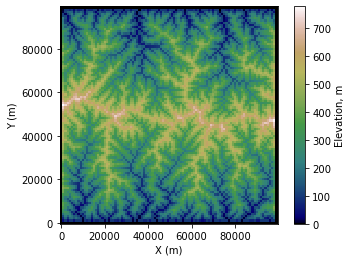

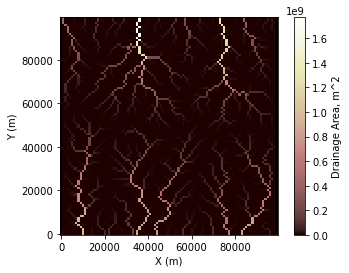

<Figure size 432x288 with 0 Axes>

In [68]:
start=time.time()
for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    
end=time.time()
print("Time per iteration =",round((end-start)/n_steps,5),"s")
print("Total runtime =",round((end-start),3),"s")
print("Peclet number =",peclet)
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

###############################################################################
###############################################################################
###############################################################################

# Model and component setup

In [77]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

## Uplift rate

Using different assumption in the uplift rate result in different surface evolution.
<br>
Here we illustrate several models based on different uplift assumptions
- no uplift
- Uniform uplift rate at the center of the area
- A one-time event that uplifts only part of the landscape
- Uplift rate is related to a fault horizontally across the grid.
- Uplift rate as a linear function of y or x
- Uplift rate as a parabolic function of y or x: Dome shape
- Uplift rate related to a normal fault using NormalFault component

![Uplift](./Uplift.jpg)

In the cell below, are a different option that you can modify the uplift rate based on a different assumption
<br>
To use it, uncomment the code lines below the option you want to explore.

In [25]:
################################################################################
## No uplift  
################################################################################
# uplift_rate = np.zeros(grid.number_of_nodes) * 0.1

################################################################################
## Uniform uplift rate
################################################################################
## Original value is 0.0001 m/yr = 0.1 m/kyr
#uplift_rate = np.ones(grid.number_of_nodes) * 0.1 

################################################################################
## Add a one-time event that uplifts only part of the landscape
################################################################################
# uplift_rate = np.ones(grid.number_of_nodes) * 0.1 
# fault_location = max(grid.y_of_node)/2  # [m]
# uplift_amount = 10 # [m]
# elev[np.nonzero(grid.node_y>fault_location)] += uplift_amount

################################################################################
## Uplift rate related with a fault horizontally across the grid
## 2-zone different uplift rate
################################################################################
## Uplift rates are greater where y values  > fault location.
# fault_location = max(grid.y_of_node)/2  # [m]
# low_uplift_rate = 0.1 # [m/kyr]
# high_uplift_rate = 0.4 # [m/kyr]
# uplift_rate[np.nonzero(grid.node_y<fault_location)] = low_uplift_rate
# uplift_rate[np.nonzero(grid.node_y>fault_location)] = high_uplift_rate

################################################################################
## Uplift rate as a linear function of y
################################################################################
## uplift_rate = m * y + b
## in this case, we assume maximum uplift rate = 0.1 and minimum uplift rate = 0
# low_uplift_rate = 0.1 # [m/kyr]
# high_uplift_rate = 0.4 # [m/kyr]
# uplift_rate_gradient = (high_uplift_rate-low_uplift_rate)/(max(grid.y_of_node)-min(grid.y_of_node))
# uplift_rate = low_uplift_rate + uplift_rate_gradient*(grid.y_of_node-min(grid.y_of_node))

## Uplift rate as a linear function of x
################################################################################
# low_uplift_rate = 0.1 # [m/kyr]
# high_uplift_rate = 0.4 # [m/kyr]
# uplift_rate_gradient = (high_uplift_rate-low_uplift_rate)/(max(grid.x_of_node)-min(grid.x_of_node))
# uplift_rate = low_uplift_rate + uplift_rate_gradient*(grid.x_of_node-min(grid.x_of_node))

################################################################################
## Uplift rate as a parabplic function of y
################################################################################
# #uplift_rate = a(y-h)^2 +k
# #In this case, we assume maximum uplift rate (Umax) = 0.1 at the middle of the area 
# #The highest uplift area is at the middle area
# #-----> at y = h -> uplift_rate = 0.4
Umax = 0.4
h = (max(grid.y_of_node)-min(grid.y_of_node))/2
k = Umax
# and minimum uplift rate (Umin) = 0 at top and bottom boundary 
# -----> at y = Ymin and Y=Ymax -> uplift_rate = 0.1
Umin = 0.1
a= (Umax-Umin)/(-(max(grid.y_of_node)-h)**2)
uplift_rate = np.zeros(grid.number_of_nodes)
uplift_rate = a*(grid.y_of_node - h)**2+k

## Uplift rate as a linear function of x
################################################################################
# #Uplift rate as a parabplic function of x
# #uplift_rate = a(x-h)^2 +k
# #In this case, we assume maximum uplift rate (Umax) = 0.1 at the middle of the area 
# #The highest uplift area is at the middle area
# -----> at x = h -> uplift_rate = 0.1
# Umax = 0.4
# h = (max(grid.x_of_node)-min(grid.x_of_node))/2
# k = Umax
# # and minimum uplift rate (Umin) = 0 at top and bottom boundary 
# # -----> at x = xmin and Y=Ymax -> uplift_rate = 0
# Umin = 0.1
# a= (Umax-Umin)/(-(max(grid.x_of_node)-h)**2)
# uplift_rate = np.zeros(grid.number_of_nodes)
# uplift_rate = a*(grid.x_of_node - h)**2+k

## Uplift rate pattern

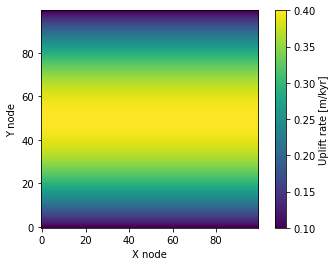

In [26]:
uplift_rate_2d = np.reshape(uplift_rate, (-1, ny))
uplift_rate_plot = plt.imshow(uplift_rate_2d,origin='lower',vmin=0.1,vmax=0.4)
plt.xlabel('X node')
plt.ylabel('Y node')
plt.colorbar(uplift_rate_plot,label= 'Uplift rate [m/kyr]')

## Model running

Running for 200 iterations
0


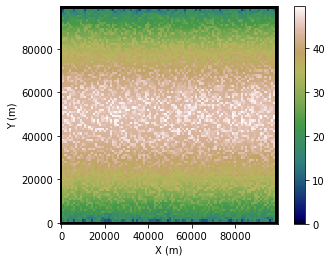

4000


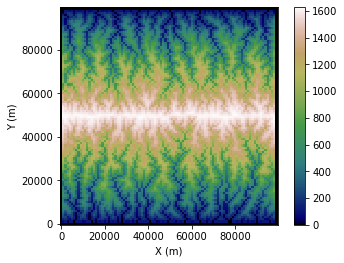

8000


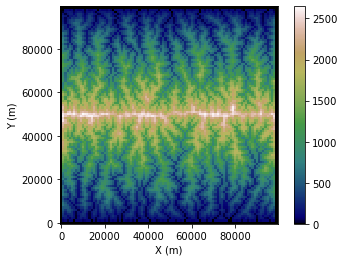

12000


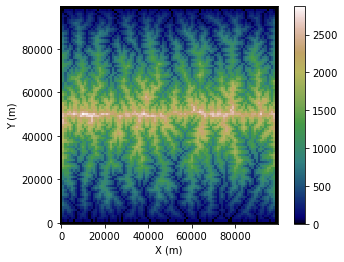

16000


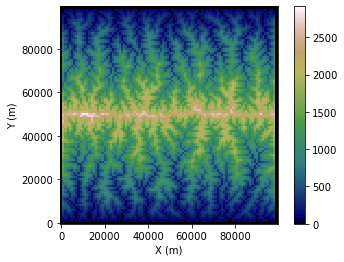

Time per iteration = 0.01521 s
Total runtime = 3.043 s
Peclet number = 100.0


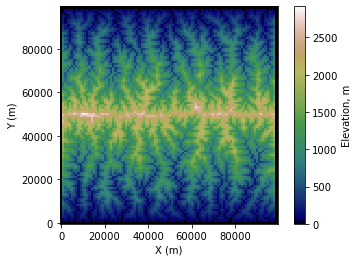

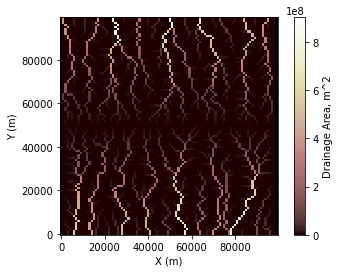

<Figure size 432x288 with 0 Axes>

In [80]:
runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 
print("Running for", n_steps, "iterations")

start=time.time()
for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    #elev += uplift_rate * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    if i % int(n_steps/5) == 0:
        print(i*dt)
        imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
end=time.time()
print("Time per iteration =",round((end-start)/n_steps,5),"s")
print("Total runtime =",round((end-start),3),"s")
print("Peclet number =",peclet)
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

# Feel free to play and explore with the different cases of uplift rate!!
## Below show landscape result of each case

## 1. No uplift

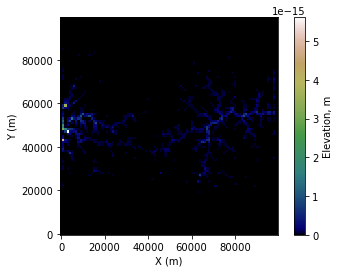

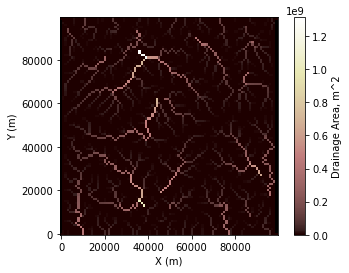

<Figure size 432x288 with 0 Axes>

In [99]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

################################################################################
## No uplift  
################################################################################
uplift_rate = np.zeros(grid.number_of_nodes) * 0.1

runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    #if i % int(n_steps/5) == 0:
        #print(i*dt)
        #imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

## 2. Uniform uplift rate

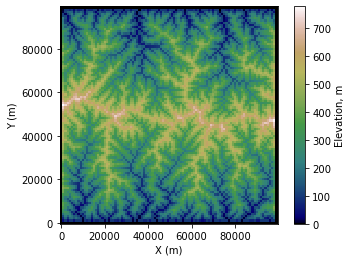

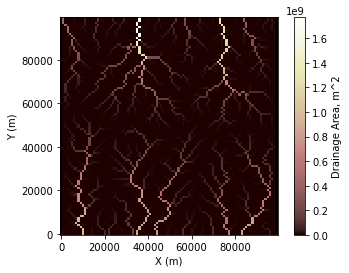

<Figure size 432x288 with 0 Axes>

In [100]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

################################################################################
## Uniform uplift rate
################################################################################
## Original value is 0.0001 m/yr = 0.1 m/kyr
uplift_rate = np.ones(grid.number_of_nodes) * 0.1 

runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    #if i % int(n_steps/5) == 0:
        #print(i*dt)
        #imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

## 3. Add a one-time event that uplifts only part of the landscape

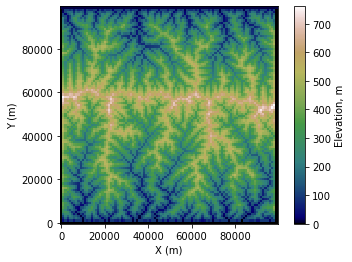

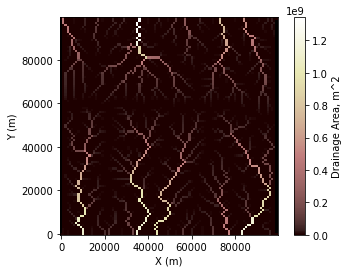

<Figure size 432x288 with 0 Axes>

In [101]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

################################################################################
## Add a one-time event that uplifts only part of the landscape
################################################################################
uplift_rate = np.ones(grid.number_of_nodes) * 0.1 
fault_location = max(grid.y_of_node)/2  # [m]
uplift_amount = 10 # [m]
elev[np.nonzero(grid.node_y>fault_location)] += uplift_amount

runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    #if i % int(n_steps/5) == 0:
        #print(i*dt)
        #imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

## 4. Uplift rate related with a fault horizontally across the grid

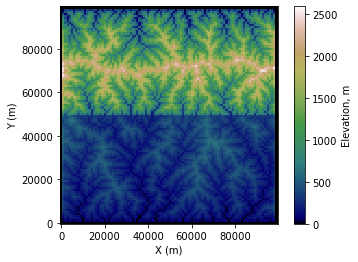

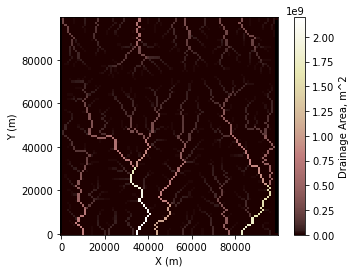

<Figure size 432x288 with 0 Axes>

In [102]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

################################################################################
## Uplift rate related with a fault horizontally across the grid
## 2-zone different uplift rate
################################################################################
# Uplift rates are greater where y values  > fault location.
fault_location = max(grid.y_of_node)/2  # [m]
low_uplift_rate = 0.1 # [m/kyr]
high_uplift_rate = 0.4 # [m/kyr]
uplift_rate[np.nonzero(grid.node_y<fault_location)] = low_uplift_rate
uplift_rate[np.nonzero(grid.node_y>fault_location)] = high_uplift_rate

runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    #if i % int(n_steps/5) == 0:
        #print(i*dt)
        #imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

## 5. Uplift rate as a linear function of y

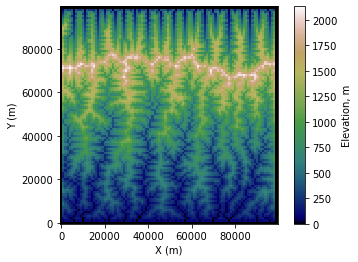

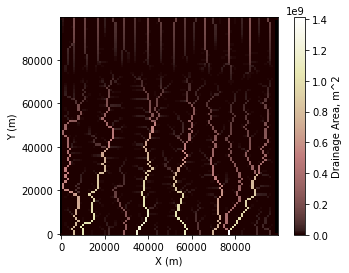

<Figure size 432x288 with 0 Axes>

In [7]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

################################################################################
## Uplift rate as a linear function of y
################################################################################
# uplift_rate = m * y + b
# in this case, we assume maximum uplift rate = 0.1 and minimum uplift rate = 0
low_uplift_rate = 0.1 # [m/kyr]
high_uplift_rate = 0.4 # [m/kyr]
uplift_rate_gradient = (high_uplift_rate-low_uplift_rate)/(max(grid.y_of_node)-min(grid.y_of_node))
uplift_rate = low_uplift_rate + uplift_rate_gradient*(grid.y_of_node-min(grid.y_of_node))

runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    #elev += uplift_rate * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    #if i % int(n_steps/5) == 0:
        #print(i*dt)
        #imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

## 6. Uplift rate as a parabolic function of y: Dome shape

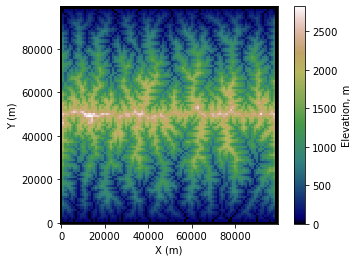

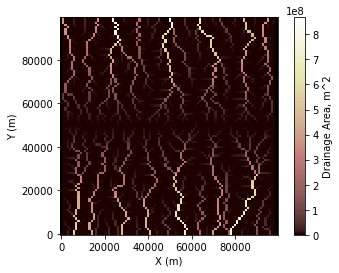

<Figure size 432x288 with 0 Axes>

In [103]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

################################################################################
## Uplift rate as a parabplic function of y
################################################################################
# #uplift_rate = a(y-h)^2 +k
# #In this case, we assume maximum uplift rate (Umax) = 0.1 at the middle of the area 
# #The highest uplift area is at the middle area
# #-----> at y = h -> uplift_rate = 0.1
Umax = 0.4
h = (max(grid.y_of_node)-min(grid.y_of_node))/2
k = Umax
# and minimum uplift rate (Umin) = 0 at top and bottom boundary 
# -----> at y = Ymin and Y=Ymax -> uplift_rate = 0
Umin = 0.1
a= (Umax-Umin)/(-(max(grid.y_of_node)-h)**2)
uplift_rate = np.zeros(grid.number_of_nodes)
uplift_rate = a*(grid.y_of_node - h)**2+k

runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    #if i % int(n_steps/5) == 0:
        #print(i*dt)
        #imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

## 7. Uplift rate related with a normal fault using NormalFault component

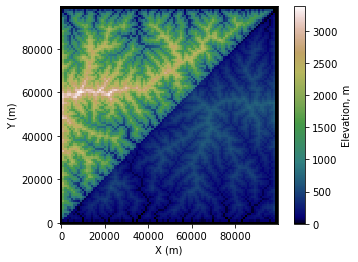

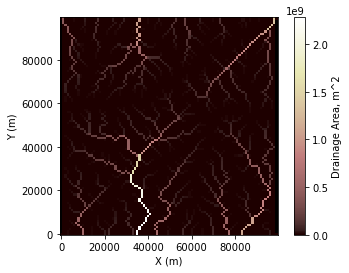

<Figure size 432x288 with 0 Axes>

In [27]:
from landlab.components import NormalFault

nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

uplift_rate = np.ones(grid.number_of_nodes) * 0.1 

param_dict = {'faulted_surface': 'topographic__elevation',
              'fault_dip_angle': 60.0,
              'fault_throw_rate_through_time': {'time': [0, 5000, 10000, 15000],'rate': [0, 0.1, 0.2,0.4]},
              'fault_trace': {'y1': 0,
                              'x1': 0,
                              'y2': 1,
                              'x2': 1},
              'include_boundaries': False}
nf = NormalFault(grid, **param_dict)
nf.faulted_nodes.reshape(grid.shape)

runtime= 20000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    #elev += uplift_rate * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    nf.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    # if i % int(n_steps/5) == 0:
    #     print(i*dt)
    #     imshow_grid(grid, 'topographic__elevation',cmap='gist_earth',output = True)
        
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

# For subplot of landscape evolution

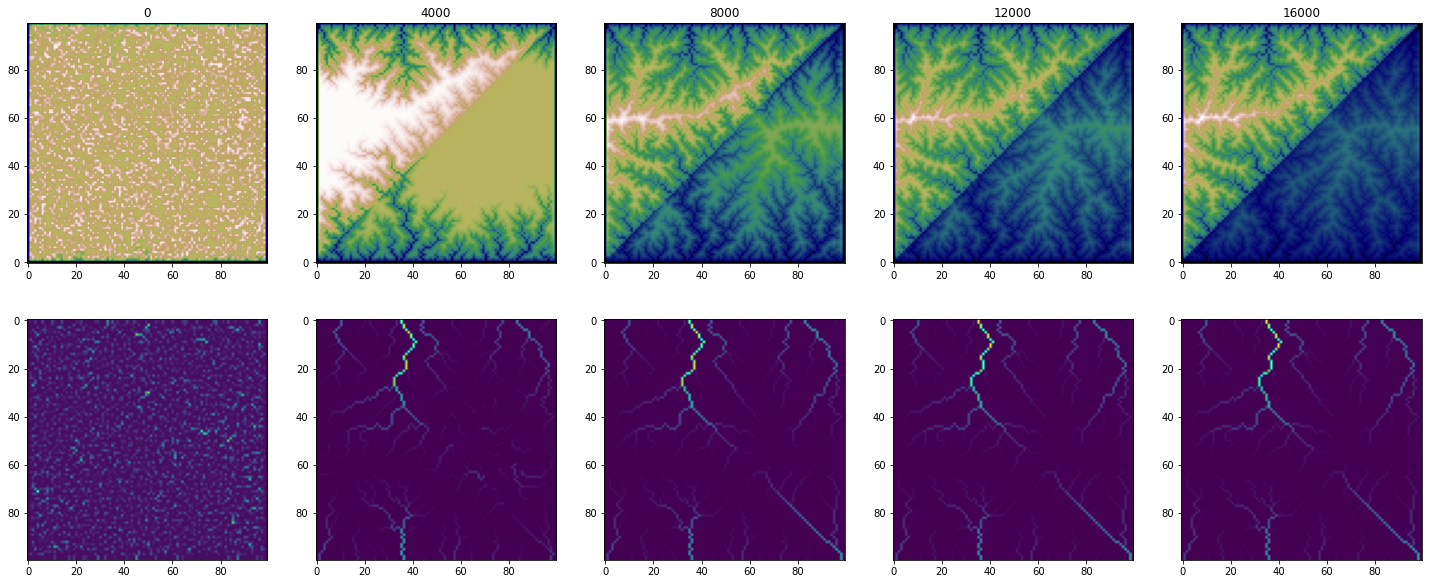

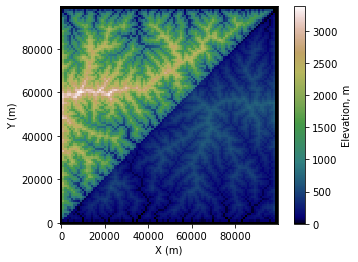

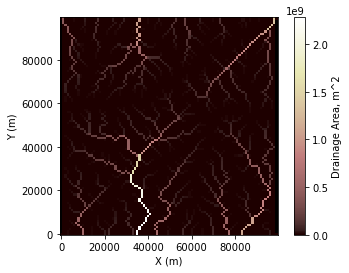

<Figure size 432x288 with 0 Axes>

In [11]:
from landlab.components import NormalFault

nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

dt = 100 # 100 kyr

uplift_rate = np.ones(grid.number_of_nodes) * 0.1 

param_dict = {'faulted_surface': 'topographic__elevation',
              'fault_dip_angle': 60.0,
              'fault_throw_rate_through_time': {'time': [0, 5000, 10000, 15000],'rate': [0, 0.1, 0.2,0.4]},
              'fault_trace': {'y1': 0,
                              'x1': 0,
                              'y2': 1,
                              'x2': 1},
              'include_boundaries': False}
nf = NormalFault(grid, **param_dict)
nf.faulted_nodes.reshape(grid.shape)

runtime= 20000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 

fig,ax = plt.subplots(2, 5,figsize=(25,10))
n_plot = 0

for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate[grid.core_nodes] * dt
    #elev += uplift_rate * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    nf.run_one_step(dt)
    #PLOT TOPOGRAPHY OF EACH TIME STEP
    if i % int(n_steps/5) == 0:
        ax[0,n_plot].imshow(grid.node_vector_to_raster(grid.at_node['topographic__elevation']), cmap='gist_earth',origin='lower')
        ax[0,n_plot].title.set_text(i*dt)
        ax[1,n_plot].imshow(grid.node_vector_to_raster(grid.at_node['drainage_area']))
        n_plot +=1
        
plt.show()
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

In [110]:
n_plot

5

In [ ]:
final_elev = grid.at_node['topographic__elevation']
f_elev_pic = grid.node_vector_to_raster(final_elev)